In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/scripts/Mixture + Analytes/5 Mixtures/')

from utils import add_noise, plot_lda_decision_boundary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re

import warnings
warnings.filterwarnings('ignore')
os.chdir('/home/soham/Desktop/GitHub/BTP/')

### LDA  

In [2]:
total_new_data = pd.read_csv('data/mixture/5 solutions/total_new_data(5 mixtures).csv')

total_new_data = total_new_data.drop(['Dilution'], axis=1)
labels = total_new_data['Label']
labels = labels.map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})

total_new_data.head()

,Sensor1,Sensor2,Sensor3,Label
0,-68.02,70.734,52.47,A1
1,-95.70,50.162,32.63,A1
2,-99.96,-8.390,-10.41,A1
3,-107.42,-18.700,-23.93,A1
4,-109.94,-19.620,-27.24,A1


In [3]:
X = total_new_data[['Sensor1','Sensor2','Sensor3']]
Y = total_new_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})
label_mapping = {0: 'Mix_101', 1: 'A1', 2: 'A2', 3: 'A3', 4: 'Mix_111'}

lda = LDA(n_components=2)
lda.fit(X, Y)
lda_data = lda.transform(X)
lda_data = pd.DataFrame(lda_data, columns=['LD1', 'LD2'])

X_train, X_test, Y_train, Y_test = train_test_split(lda_data, Y, test_size=0.2, random_state=np.random.randint(0,100))

lda_data.head()

,LD1,LD2
0,-3.188712,1.714135
1,-3.364710,0.916712
2,-2.092924,-1.016408
3,-2.052451,-1.392063
4,-2.101869,-1.435814


### SVM on 5 Classes

In [4]:
svm = SVC(kernel='rbf')
svm.fit(X_train, Y_train)

print('Training accuracy = ', svm.score(X_train, Y_train))

pred = svm.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))

Training accuracy =  0.925
Testing accuracy =  1.0


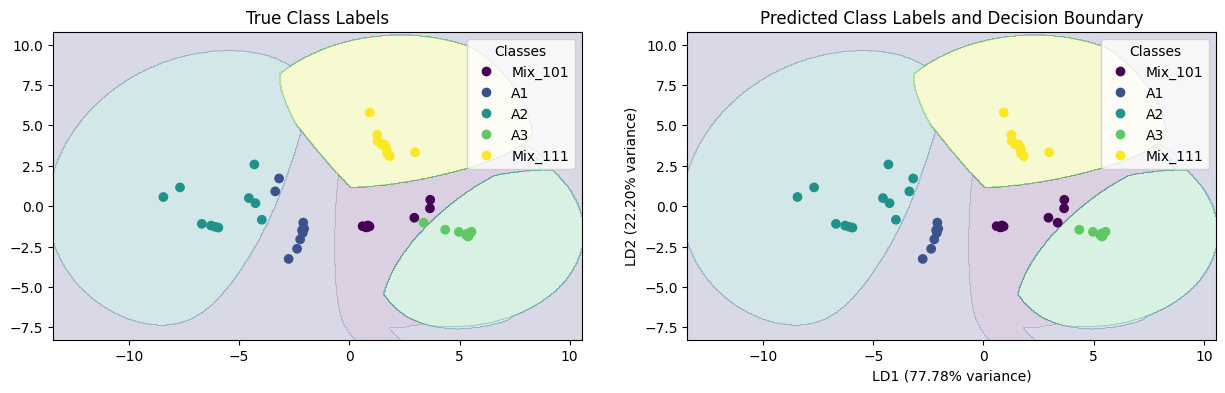

In [6]:
lda_data['Labels'] = total_new_data['Label']
plot_lda_decision_boundary(lda, lda_data, svm, label_mapping)

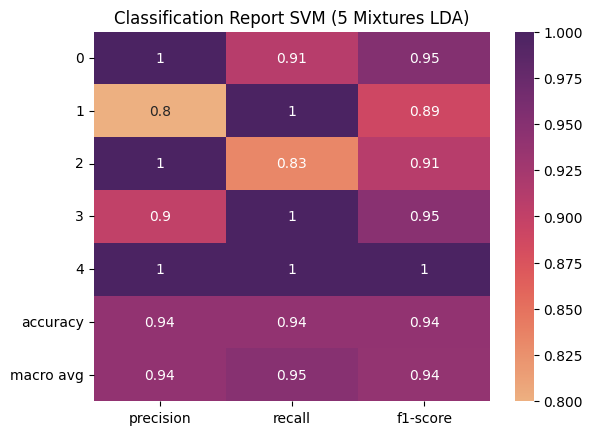

In [7]:
''' Confusion matrix '''

predictions = svm.predict(lda_data[['LD1','LD2']])
report = classification_report(predictions, Y, output_dict=True)
report = pd.DataFrame(report).transpose()

sns.heatmap(report.iloc[:-1, :-1], annot=True, cmap='flare')
plt.title('Classification Report SVM (5 Mixtures LDA)')
plt.show()

## Additional Noise Points

### SVM

Noise Level: 0.05
Training accuracy =  0.9785714285714285
Testing accuracy =  0.9714285714285714


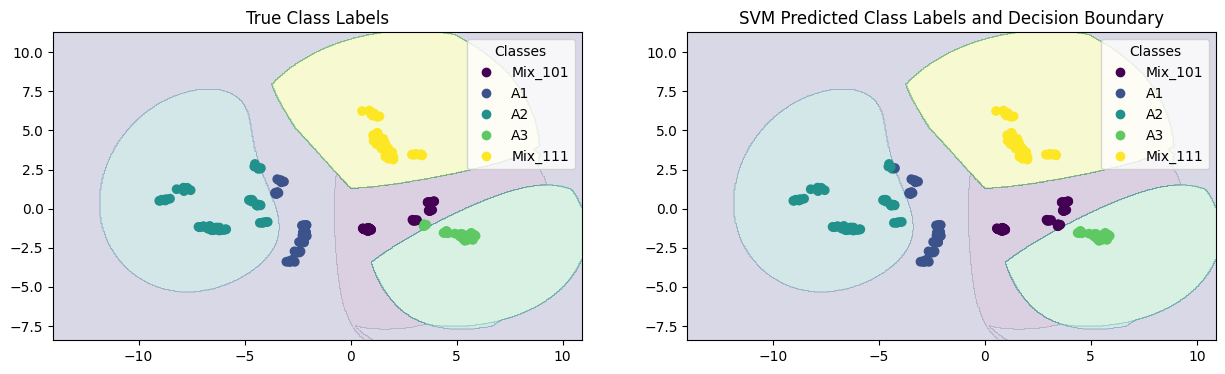

Noise Level: 0.1
Training accuracy =  0.9642857142857143
Testing accuracy =  0.9714285714285714


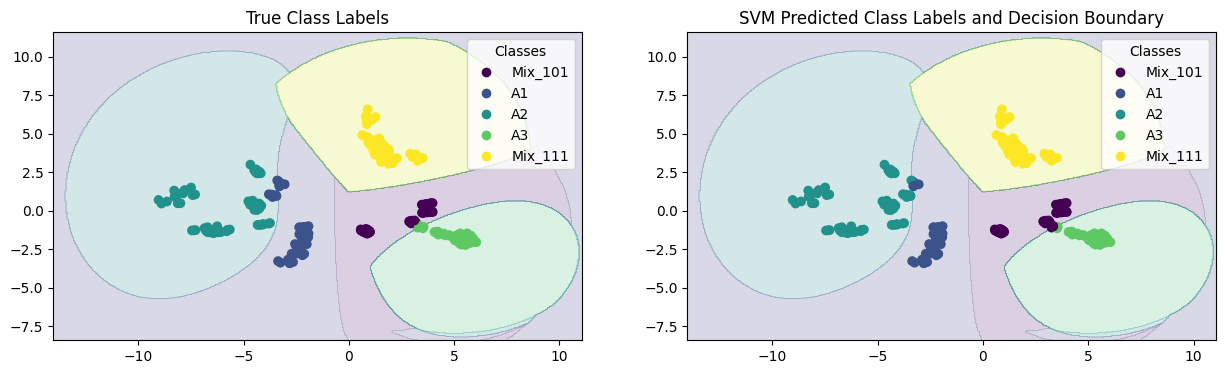

Noise Level: 0.15
Training accuracy =  0.9678571428571429
Testing accuracy =  0.9285714285714286


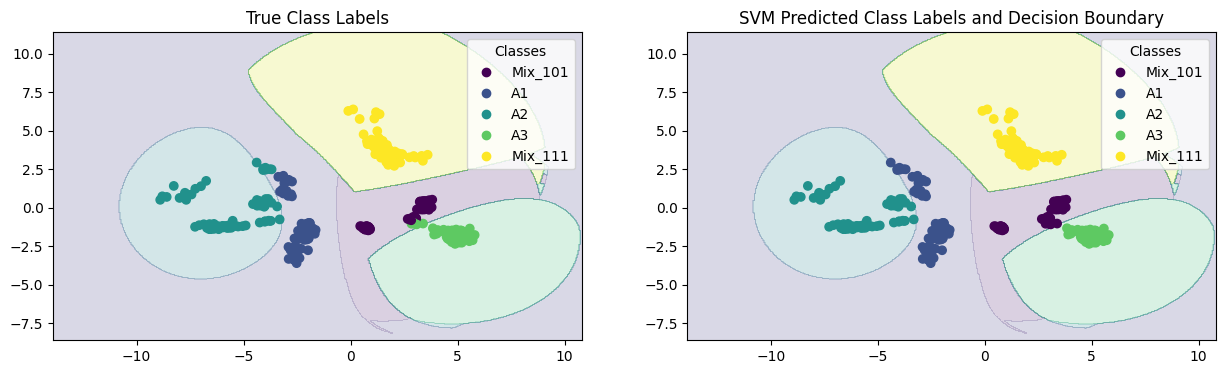

Noise Level: 0.2
Training accuracy =  0.975
Testing accuracy =  0.9285714285714286


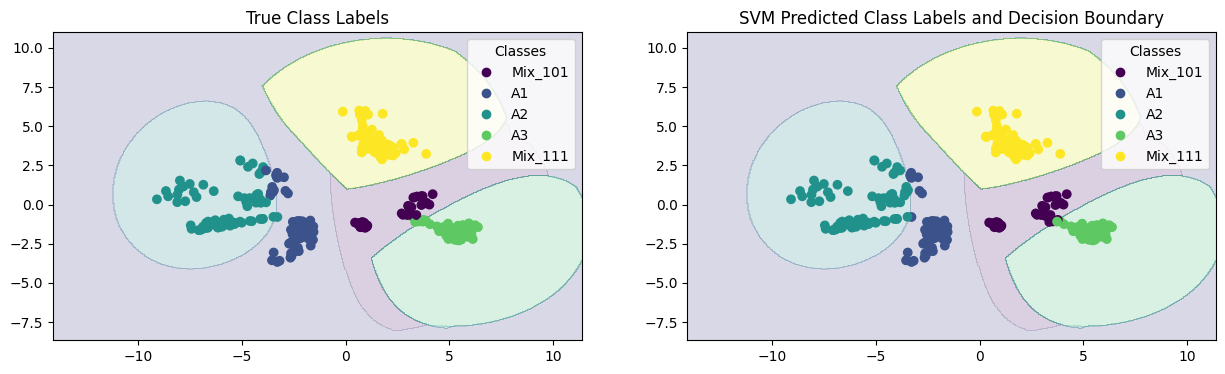

Noise Level: 0.25
Training accuracy =  0.975
Testing accuracy =  0.9571428571428572


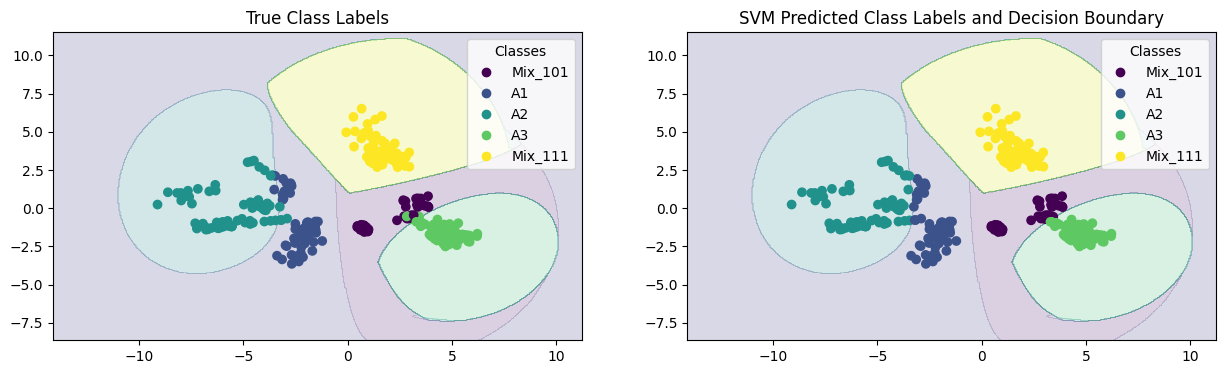

In [10]:
for p in [0.05, 0.10, 0.15, 0.2, 0.25]:

    # Adding noise to the data

    print(f'Noise Level: {p}')
    data_noisy, noisy_labels = add_noise(total_new_data[['Sensor1', 'Sensor2', 'Sensor3']], total_new_data['Label'], p)


    lda = LDA(n_components=2)
    lda_data = lda.fit_transform(data_noisy, noisy_labels)
    lda_data = pd.DataFrame(lda_data, columns=['LD1','LD2'])
    lda_data['Label'] = noisy_labels


    # Split into training and testing data

    Y = lda_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})
    X = lda_data.drop(['Label'], axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0,100))

    svm = SVC(kernel='rbf')
    svm.fit(X_train, Y_train)
    print('Training accuracy = ', svm.score(X_train, Y_train))

    pred = svm.predict(X_test)
    print('Testing accuracy = ', accuracy_score(Y_test, pred))

    # Plotting

    predictions = svm.predict(X)

    x_min, x_max = lda_data['LD1'].min() - 5, lda_data['LD1'].max() + 5
    y_min, y_max = lda_data['LD2'].min() - 5, lda_data['LD2'].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = svm.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
    Z = Z.reshape(xx.shape)

    # PLOTTING THE DECISION BOUNDARY 

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[0].scatter(lda_data['LD1'], lda_data['LD2'], c=Y, cmap='viridis')
    legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")

    handles, labels = scatter.legend_elements()
    labels = [label_mapping[int(re.search(r'\d+', label).group())] for label in labels]
    ax[0].legend(handles, labels, title="Classes")
    ax[0].set_title('True Class Labels')

    ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[1].scatter(lda_data['LD1'], lda_data['LD2'], c=predictions, cmap='viridis')
    legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")

    handles, labels = scatter.legend_elements()
    labels = [label_mapping[int(re.search(r'\d+', label).group())] for label in labels]
    ax[1].legend(handles, labels, title="Classes")
    ax[1].set_title('SVM Predicted Class Labels and Decision Boundary')

    plt.show()